# **HW5: Autoencoders**

In this homework, we will explore how to develop a simple Autoencoder. As a dataset, we will use the MNIST dataset. It contains handwritten digits images.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version of it. Next, we will experiment with the application of a denoising autoencoder. Finally, we will experiment with sequential domains, considering the IMDB dataset, alredy used in HW4.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

###Load Dataset
We load the MNIST dataset, using tf.keras.datasets. The dataset contains 60,000 training images and 10,000 testing images.
Each value is between 0 and 255, and represents a pixel in an image of size 28 x 28. We will normalize all values between 0 and 1, and we will flatten the 28x28 images into vectors of size 784.
Finally, we will split the test set, in the test and validation set.

In [ ]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid = x_train[:10000]
x_train = x_train[10000:]

##Singular Value Decomposition

Principal component analysis (PCA) and singular value decomposition (SVD) are both classical linear dimensionality reduction methods that attempt to find linear combinations of features in the original high dimensional data matrix to construct a meaningful representation of the dataset.
In this first part of the HW we will focus our attention on SVD decomposition. Indeed it is more numerical stable. Given a matrix X, the SVD decomposes a matrix into the product of two unitary matrices V and U and a rectangular diagonal matrix of singular values S:

$$ X=V \cdot S \cdot U^T$$

SVD is implemented in NumPy as np.linalg.svd. In our case the X matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features).

Note that the X matrix, in our case, will have a huge number of rows (we have 50000 input samples) and only 784 columns. Therefore, to optimize the memory consumption we can compute the SVD of the covariance matrix. An interesting property of the SVD is that we can relate the decomposition of the covariance matrix $C= X^T \cdot X$ to the decomposition of $X$. In fact

$$ C= X^T \cdot X = U \cdot S \cdot V^T \cdot V\cdot S \cdot U^T  = U \cdot S^2 \cdot U^T$$

Since we need just the matrix U to compute the compressed version of our data, this method will be very convenient. If you are using the Colab free plan, the quantity of available ram is not sufficient to compute the SVD of X, therefore computing the SVD of the covariance matrix turns out to be the best solution. 

In [ ]:
def svd_k(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k


Let's define the ENCODING_DIM, that will be the size of the compressed version of input data, and compute the compressed version of the training set and the test set.

**To complete: What happens varying the ENCODING_DIM? 

How we can see from next pictures, the greater ENCODING_DIM is, the better representation we get from svd decomposition. In particular, we can visibly see how the numbers are the more out of focus, the smaller the dimensions are.



In [ ]:
ENCODING_DIM = [20,50,100,200,400]
def plot_img(n, input_data, decoded_imgs):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(input_data[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()  
    
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

mse for 20 dimensions: 
training mse: 0.02405
test mse: 0.02356


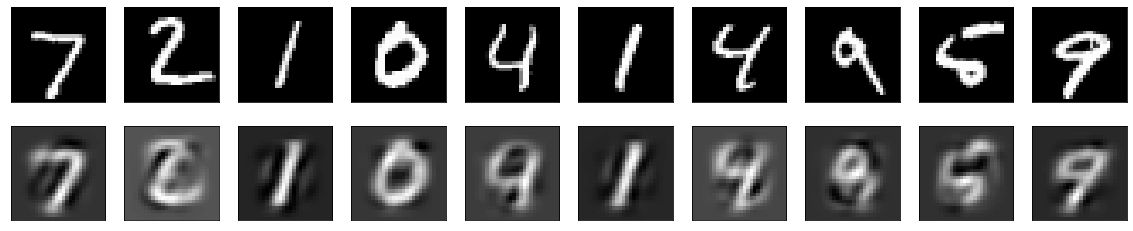

mse for 50 dimensions: 
training mse: 0.01183
test mse: 0.01150


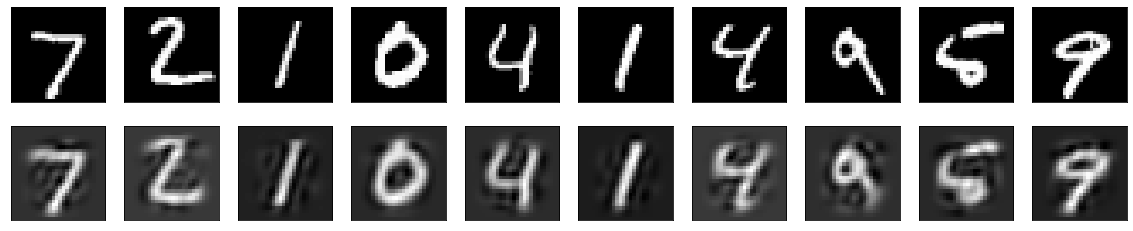

mse for 100 dimensions: 
training mse: 0.00575
test mse: 0.00562


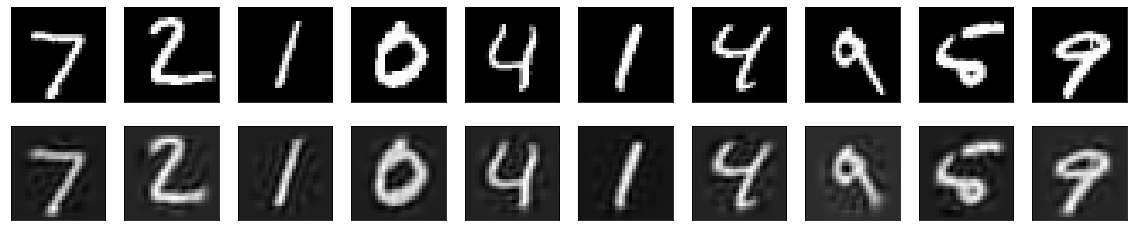

mse for 200 dimensions: 
training mse: 0.00226
test mse: 0.00224


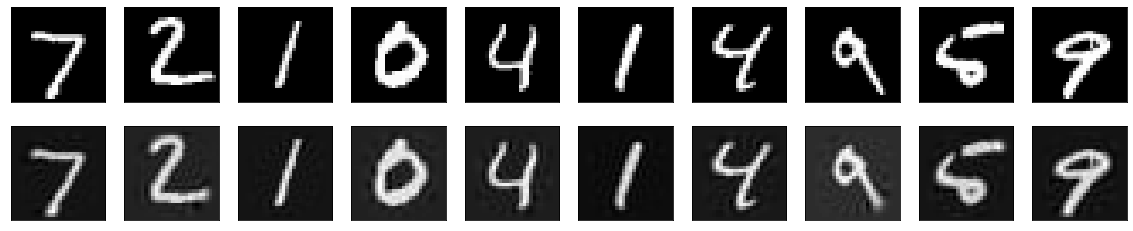

mse for 400 dimensions: 
training mse: 0.00028
test mse: 0.00027


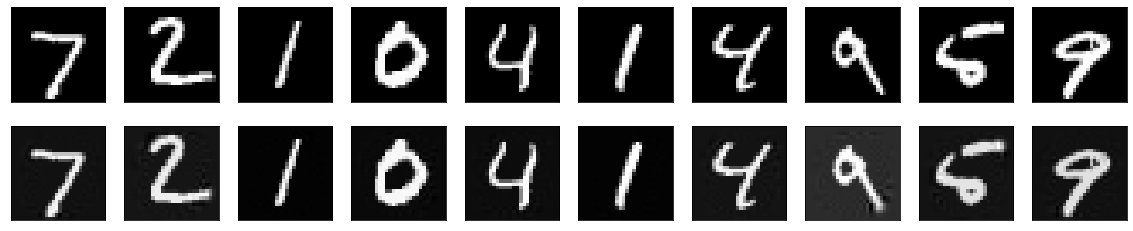

In [ ]:
train_mses_svg, test_mses_svg = [], []
for i in ENCODING_DIM:
    U_k=svd_k(x_train, i)

    x_training_pca = np.dot(x_train, U_k)
    x_test_pca = np.dot(x_test, U_k)

    x_training_reco= np.dot(x_training_pca, U_k.T)
    x_test_reco= np.dot(x_test_pca, U_k.T)

    accuracy_train = ((x_train - x_training_reco)**2).mean()
    accuracy_test = ((x_test - x_test_reco)**2).mean()
    print("mse for {} dimensions: ".format(i))
    print("training mse: %.5f" % ( accuracy_train))
    print("test mse: %.5f" % ( accuracy_test))
    train_mses_svg.append(accuracy_train)
    test_mses_svg.append(accuracy_test)
    plot_img(10, x_test, x_test_reco)


## Exercise 5.1: Shallow Linear Autoencoder
Let's define the model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous homework, instead of using Keras.Sequential(), we define the various parts of the model (encoder and decoder) separately and create the final model. 

**To complete: check the results and compare them with the results obtained by SVD. Add a cell  at the end of this section (after the result of the linear autoencoder) where you give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.**


In [ ]:
scores_sl, decodeds_sl, hist_sl = [], [], []

for i in ENCODING_DIM:

    input_img = tf.keras.layers.Input(shape=(784,))
    encoded = tf.keras.layers.Dense(i, activation='linear')(input_img)#Define the encoder...
    decoded = tf.keras.layers.Dense(784, activation='linear')(encoded)#...and the decoder...
    autoencoder = tf.keras.models.Model(input_img, decoded)#and finally the autoencoder
    # In order to visualize the learned encoding, define a model that computes the two parts separately.
    encoder = tf.keras.models.Model(input_img, encoded)
    encoded_input = tf.keras.layers.Input(shape=(i,))
    decoder_layer = autoencoder.layers[-1]
    decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')#Finally, let's call the compile method
    autoencoder.summary()
    history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))
    hist_sl.append(history)
    score = autoencoder.evaluate(x_test, x_test, verbose=2)
    scores_sl.append(score)
    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = decoder.predict(encoded_imgs)
    decodeds_sl.append(decoded_imgs)


Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_133 (Dense)            (None, 20)                15700     
_________________________________________________________________
dense_134 (Dense)            (None, 784)               16464     
Total params: 32,164
Trainable params: 32,164
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
98/98 [==============================] - 1s 10ms/step - loss: 0.0431 - val_loss: 0.0259
Epoch 2/15
98/98 [==============================] - 1s 9ms/step - loss: 0.0250 - val_loss: 0.0242
Epoch 3/15
98/98 [==============================] - 1s 9ms/step - loss: 0.0244 - val_loss: 0.0241
Epoch 4/15
98/98 [==============================] - 1s 9ms/step - loss: 0.0244 - val_loss

Losses with 20 dimensions:
test mse: 0.02382
Losses with 50 dimensions:
test mse: 0.01186
Losses with 100 dimensions:
test mse: 0.00590
Losses with 200 dimensions:
test mse: 0.00258
Losses with 400 dimensions:
test mse: 0.00134


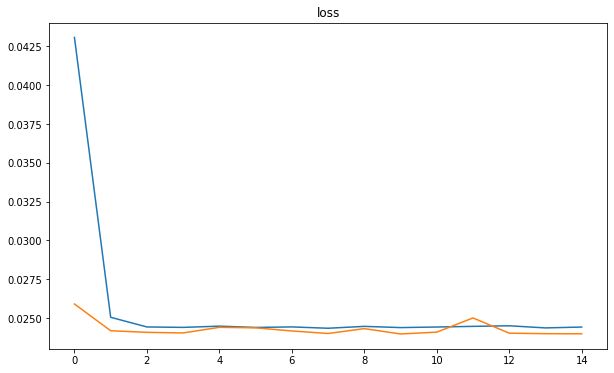

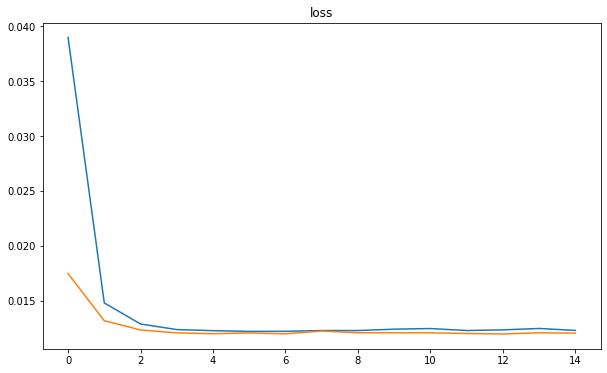

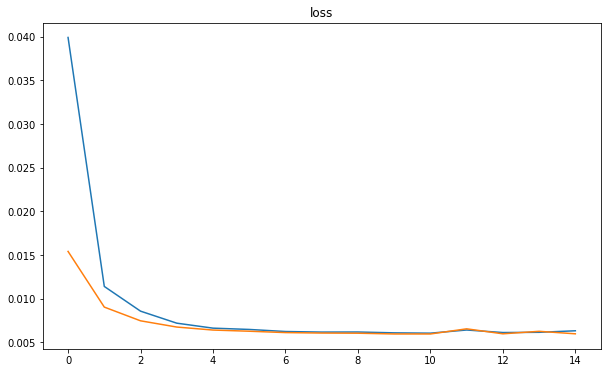

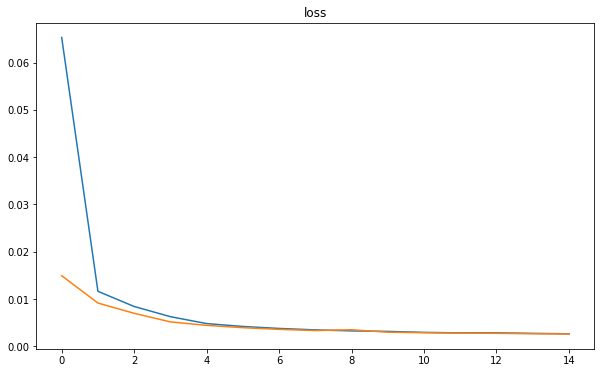

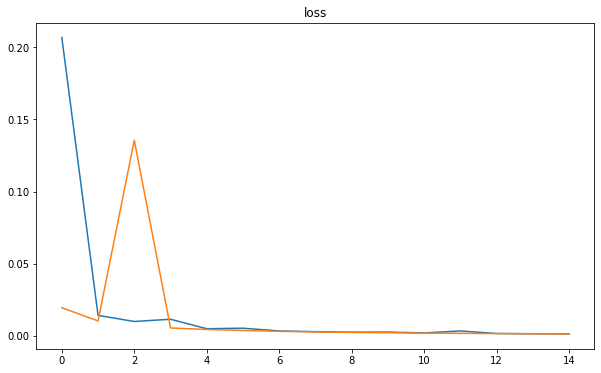

In [ ]:
for i in range(len(ENCODING_DIM)):
    print("Losses with {} dimensions:".format(ENCODING_DIM[i]))
    print("test mse: %.5f" % (scores_sl[i]))
    plot_loss(hist_sl[i])

Decoded images with 20 dimensions:


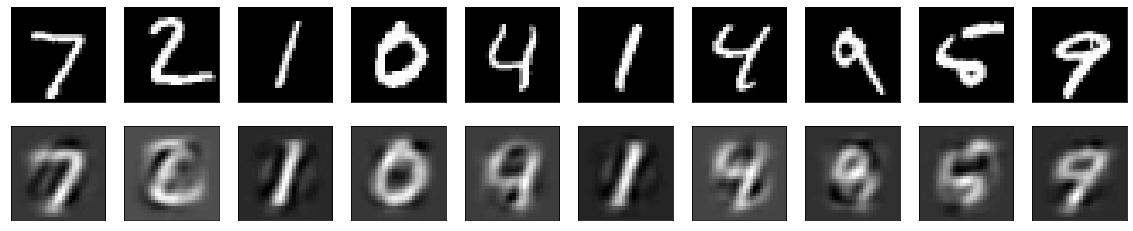

Decoded images with 50 dimensions:


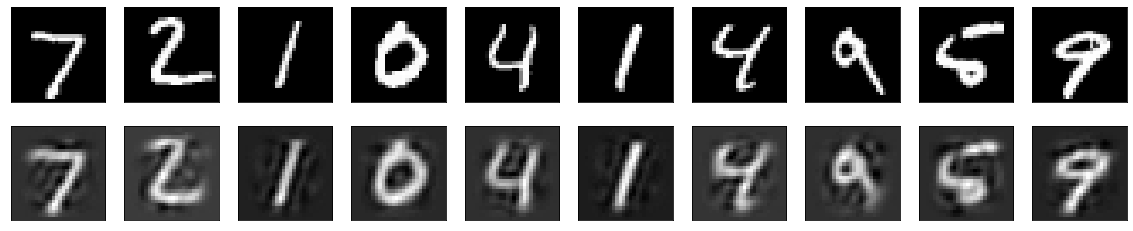

Decoded images with 100 dimensions:


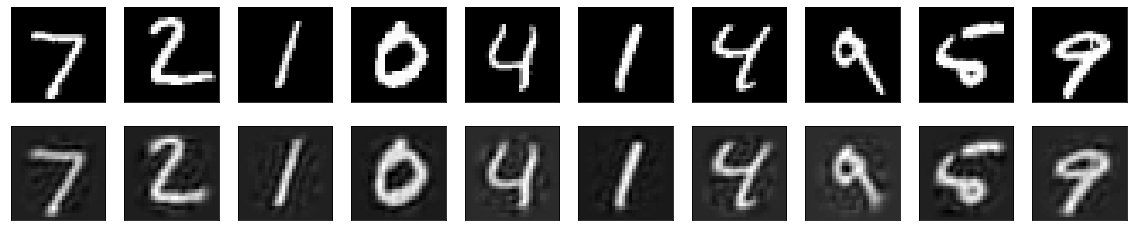

Decoded images with 200 dimensions:


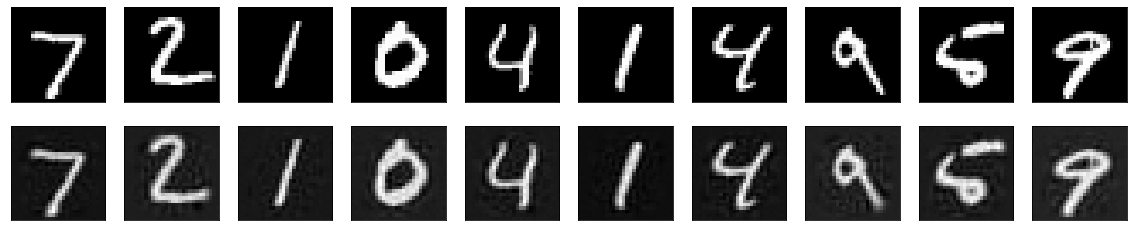

Decoded images with 400 dimensions:


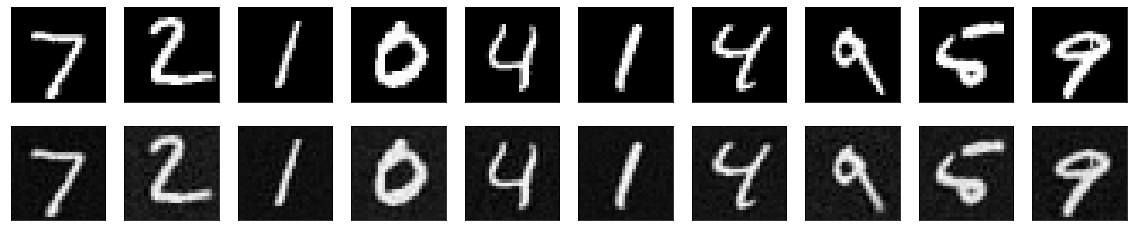

In [ ]:
for i in range(len(ENCODING_DIM)):
    print("Decoded images with {} dimensions:".format(ENCODING_DIM[i]))
    plot_img(10, x_test, decodeds_sl[i])

In [ ]:
print(test_mses_svg)
print(scores_sl)

[0.02355809, 0.011498539, 0.0056200684, 0.0022351777, 0.00027204095]
[0.023819372057914734, 0.011859315447509289, 0.0058989557437598705, 0.0025785204488784075, 0.001342412899248302]


How we can see, the results on the training set are pretty similar between SVD decomposition and shallow linear autoencoders. This is why, if we use only one linear layer, the weights learned by the autoencoder, recreates a similar vector subspace of the first principal components and the output is a projection on that space. So, by using the SVD decomposition, would be possible to recover the first principal components.

##Exercise  5.2: Shallow non-linear autoencoders

**To complete: replicate the code of exercise 5.1 but in this case, instead of using linear activation functions use non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.1.**


In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

In [ ]:
scores_snl, decodeds_snl, hist_snl = [], [], []

for i in ENCODING_DIM:

    input_img = tf.keras.layers.Input(shape=(784,))
    encoded = tf.keras.layers.Dense(i, activation='sigmoid')(input_img)#Define the encoder...
    decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)#...and the decoder...
    autoencoder = tf.keras.models.Model(input_img, decoded)#and finally the autoencoder
    # In order to visualize the learned encoding, define a model that computes the two parts separately.
    encoder = tf.keras.models.Model(input_img, encoded)
    encoded_input = tf.keras.layers.Input(shape=(i,))
    decoder_layer = autoencoder.layers[-1]
    decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')#Finally, let's call the compile method
    autoencoder.summary()
    history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=32, shuffle=True, validation_data=(x_valid, x_valid))
    hist_snl.append(history)
    score = autoencoder.evaluate(x_test, x_test, verbose=2)
    scores_snl.append(score)
    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = decoder.predict(encoded_imgs)
    decodeds_snl.append(decoded_imgs)


Model: "model_137"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_96 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_203 (Dense)            (None, 20)                15700     
_________________________________________________________________
dense_204 (Dense)            (None, 784)               16464     
Total params: 32,164
Trainable params: 32,164
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0683 - val_loss: 0.0678
Epoch 2/15
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0638 - val_loss: 0.0616
Epoch 3/15
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0616 - val_loss: 0.0612
Epoch 4/15
1563/1563 [==============================] - 4s 2ms/step - loss: 0

Losses with 20 dimensions:
test mse: 0.04325
Losses with 50 dimensions:
test mse: 0.00792
Losses with 100 dimensions:
test mse: 0.00394
Losses with 200 dimensions:
test mse: 0.00295
Losses with 400 dimensions:
test mse: 0.00307


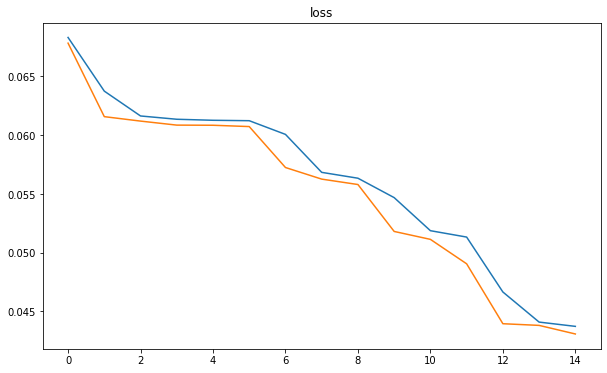

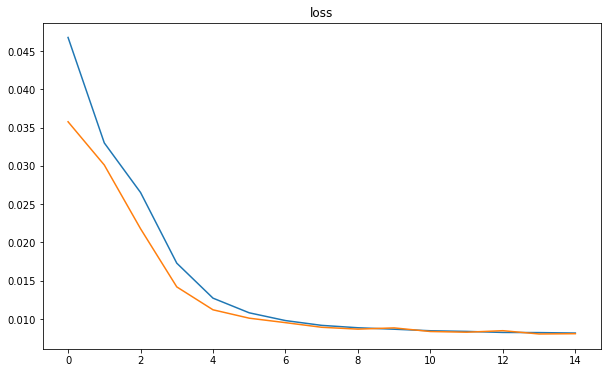

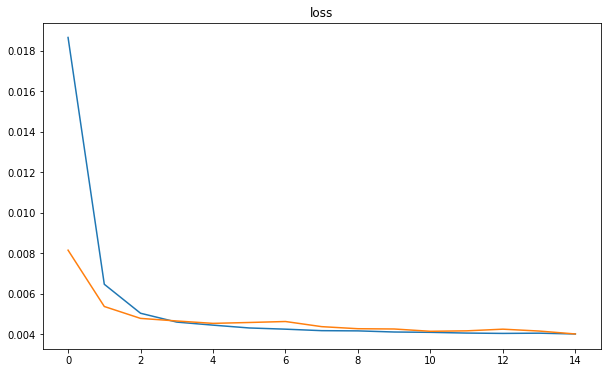

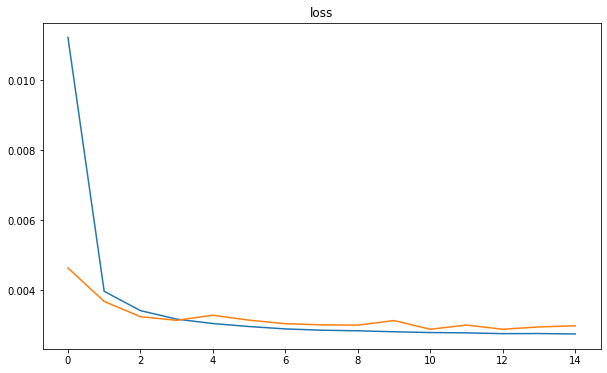

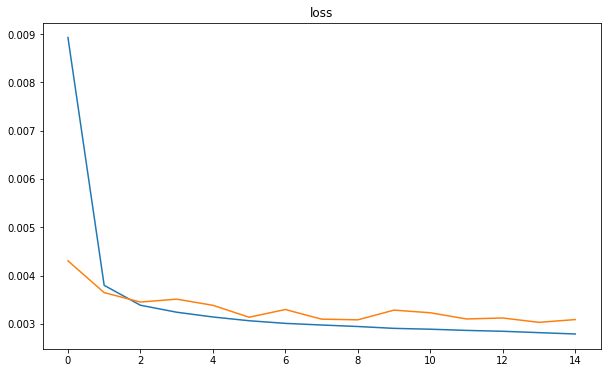

In [ ]:
for i in range(len(ENCODING_DIM)):
    print("Losses with {} dimensions:".format(ENCODING_DIM[i]))
    print("test mse: %.5f" % (scores_snl[i]))
    plot_loss(hist_snl[i])

Decoded images with 20 dimensions:


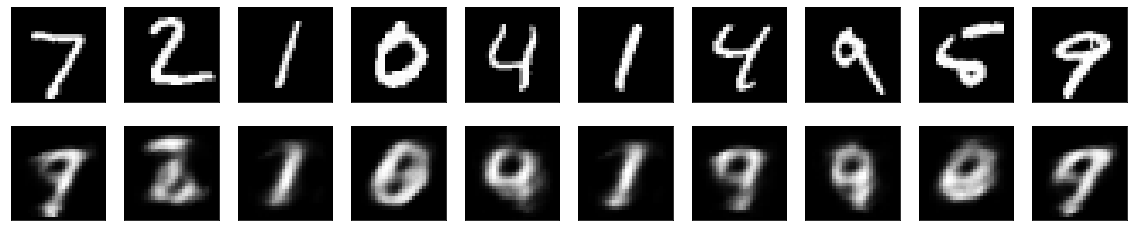

Decoded images with 50 dimensions:


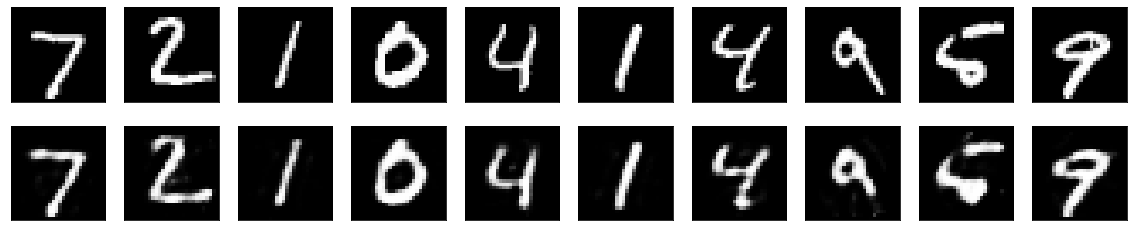

Decoded images with 100 dimensions:


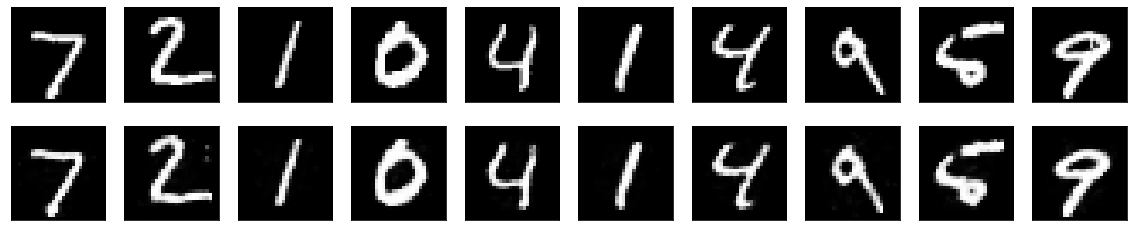

Decoded images with 200 dimensions:


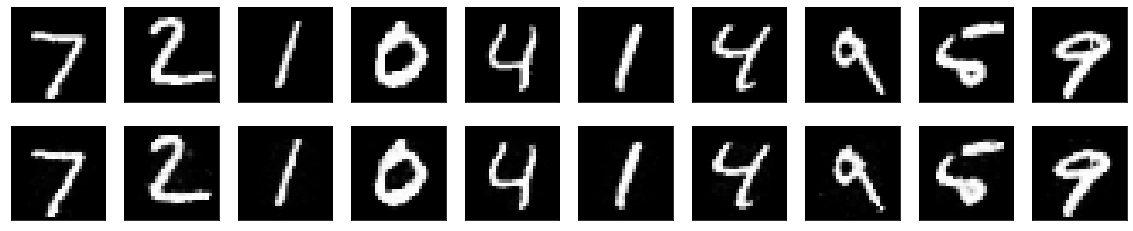

Decoded images with 400 dimensions:


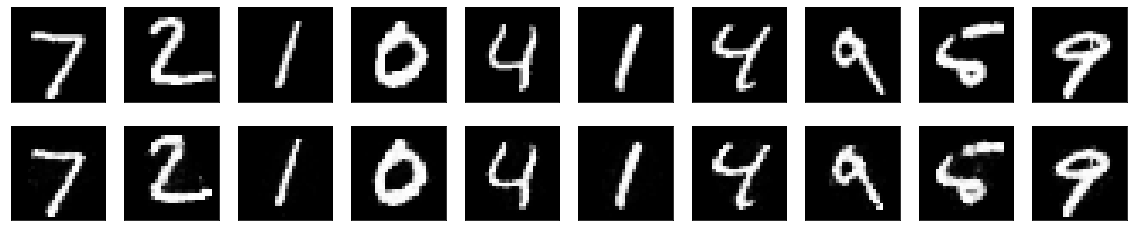

In [ ]:
for i in range(len(ENCODING_DIM)):
    print("Decoded images with {} dimensions:".format(ENCODING_DIM[i]))
    plot_img(10, x_test, decodeds_snl[i])

Here i chose to use the sigmoid activation function, since our data is in range [0,1] as the output of the activation function. Results obtained are better than linear autoencoder with values of the loss lower than the other. Also, results obtained by non linearity are same for 200 and 400 dimension, while for linear autoencoder they change much. 

## Exercise 5.3: Deep Autoencoder
**To_complete: Define a deep version of the Autoeancoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and n-1 for decoding. The layers sizes of the encoding part decrease at each layer (e.g., 748->128->64, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e, 128->748, the resulting structure recall an hourglass).
Similarly than what did above, print the model summary, the loss curve during the training, the achieved loss on the test set, and some input image with the correspondent decoding.**


In [ ]:
ENCODING_DIM = [20,50,100,200,400]
img_dim = 784

In [ ]:
input_img = tf.keras.layers.Input(shape=(img_dim,))
encoded = tf.keras.layers.Dense(ENCODING_DIM[4], activation='relu')(input_img)
encoded = tf.keras.layers.Dense(ENCODING_DIM[3], activation='relu')(encoded)
encoded = tf.keras.layers.Dense(ENCODING_DIM[2], activation='relu')(encoded)
encoded = tf.keras.layers.Dense(ENCODING_DIM[1], activation='relu')(encoded)
encoded = tf.keras.layers.Dense(ENCODING_DIM[0], activation='relu')(encoded)

decoded = tf.keras.layers.Dense(ENCODING_DIM[1], activation='relu')(encoded)
decoded = tf.keras.layers.Dense(ENCODING_DIM[2], activation='relu')(decoded)
decoded = tf.keras.layers.Dense(ENCODING_DIM[3], activation='relu')(decoded)
decoded = tf.keras.layers.Dense(ENCODING_DIM[4], activation='relu')(decoded)
decoded = tf.keras.layers.Dense(img_dim, activation='sigmoid')(decoded)

autoencoder = tf.keras.models.Model(input_img, decoded)

encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM[4],))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))


autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

autoencoder.summary()
history = autoencoder.fit(x_train, x_train, epochs=20, batch_size=1024, shuffle=True, validation_data=(x_valid, x_valid))



Model: "model_152"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_106 (InputLayer)       [(None, 784)]             0         
_________________________________________________________________
dense_213 (Dense)            (None, 400)               314000    
_________________________________________________________________
dense_214 (Dense)            (None, 200)               80200     
_________________________________________________________________
dense_215 (Dense)            (None, 100)               20100     
_________________________________________________________________
dense_216 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_217 (Dense)            (None, 20)                1020      
_________________________________________________________________
dense_218 (Dense)            (None, 50)                10

313/313 - 1s - loss: 0.0317
test mse: 0.03169


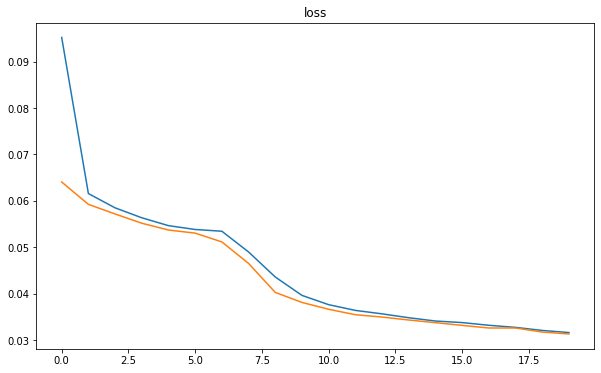

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

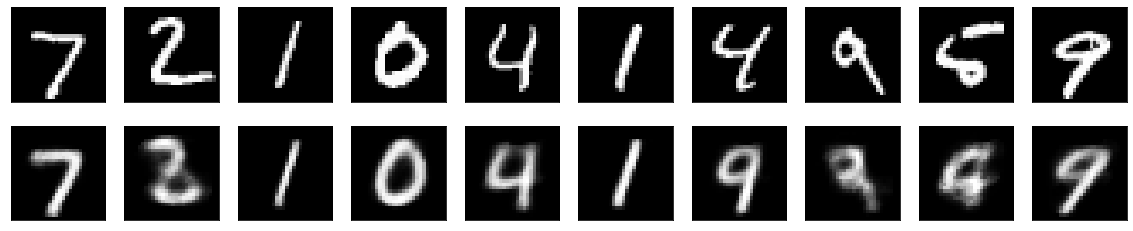

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, x_test, decoded_imgs)


## Exercise 5.4: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data.
Firstly, define a noisy input by adding some noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data, and to check how much it influences the denoising capability of the autoencoder.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000],y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

noise_factor = 0.3

x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)


x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs.

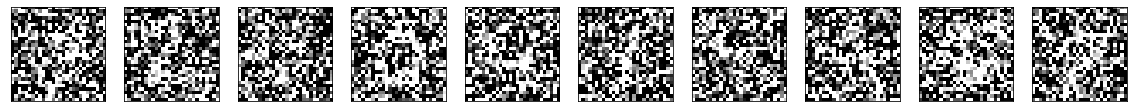

In [ ]:
# here's what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
input_img = tf.keras.layers.Input(shape=(img_dim,))
encoded_noisy = tf.keras.layers.Dense(ENCODING_DIM[4], activation='relu')(input_img)
encoded_noisy = tf.keras.layers.Dense(ENCODING_DIM[3], activation='relu')(encoded_noisy)
encoded_noisy = tf.keras.layers.Dense(ENCODING_DIM[2], activation='relu')(encoded_noisy)
encoded_noisy = tf.keras.layers.Dense(ENCODING_DIM[1], activation='relu')(encoded_noisy)
encoded_noisy = tf.keras.layers.Dense(ENCODING_DIM[0], activation='relu')(encoded_noisy)

decoded_noisy = tf.keras.layers.Dense(ENCODING_DIM[1], activation='relu')(encoded_noisy)
decoded_noisy = tf.keras.layers.Dense(ENCODING_DIM[2], activation='relu')(decoded_noisy)
decoded_noisy = tf.keras.layers.Dense(ENCODING_DIM[3], activation='relu')(decoded_noisy)
decoded_noisy = tf.keras.layers.Dense(ENCODING_DIM[4], activation='relu')(decoded_noisy)
decoded_noisy = tf.keras.layers.Dense(img_dim, activation='sigmoid')(decoded_noisy)

autoencoder_noisy = tf.keras.models.Model(input_img, decoded_noisy)

autoencoder_noisy.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
autoencoder_noisy.summary()
history_noisy = autoencoder_noisy.fit(x_train_noisy, x_train, epochs=50, batch_size=128, shuffle=True, validation_data=(x_valid_noisy, x_valid))


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_110 (Dense)            (None, 400)               314000    
_________________________________________________________________
dense_111 (Dense)            (None, 200)               80200     
_________________________________________________________________
dense_112 (Dense)            (None, 100)               20100     
_________________________________________________________________
dense_113 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_114 (Dense)            (None, 20)                1020      
_________________________________________________________________
dense_115 (Dense)            (None, 50)                105

313/313 - 1s - loss: 0.0394
test mse: 0.03935


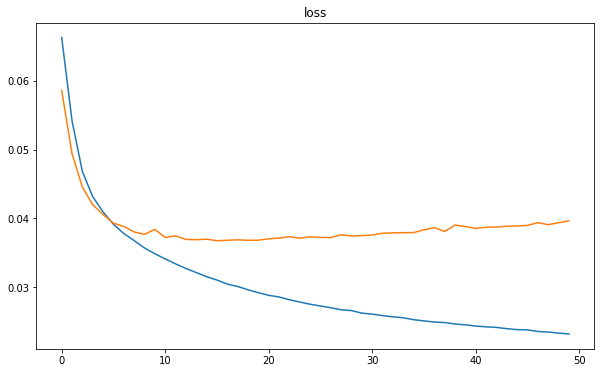

In [ ]:
plot_loss(history_noisy)

scores_noisy = autoencoder_noisy.evaluate(x_test_noisy, x_test, verbose=2)
print("test mse: %.5f" % (scores_noisy))

Check the result by plotting some input images and the correspondent denoised outputs

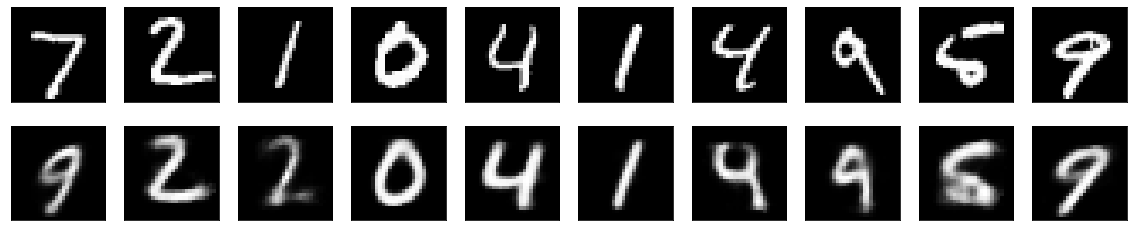

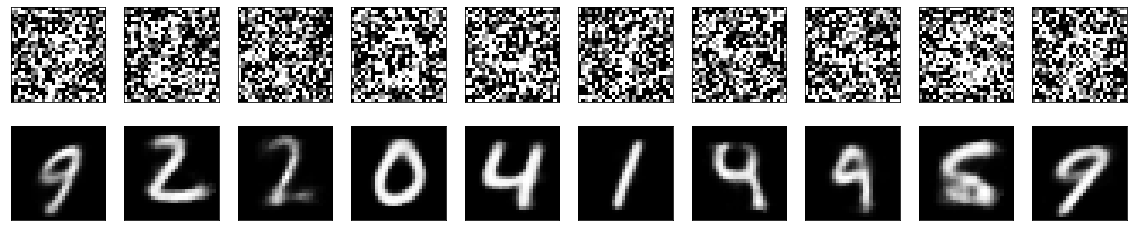

In [ ]:
decoded_imgs_noisy = autoencoder_noisy.predict(x_test_noisy)
plot_img(10, x_test, decoded_imgs_noisy)
plot_img(10, x_test_noisy, decoded_imgs_noisy)

## Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case, as dataset, we will use the IMDB dataset (already presented in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in Colab), we will limit the number of training samples and test samples.

In [ ]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])


maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by the IMDB dataset loader, we use the to_categorical method to transform them in the correspondent one-hot representations.

In [ ]:
from keras.utils import to_categorical

X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)
X_train_one_hot[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in exercise 5.1, while the encoding layer is defined by using tf.keras.layers.SimpleRNN. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense layer on each time step of the sequence. 

Since the output will be a one-hot representation, let's use the binary_crossentropy as loss and the CategoricalAccuracy as metric.

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 90, 50)            7550      
_________________________________________________________________
time_distributed (TimeDistri (None, 90, 100)           5100      
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 6s 79ms/step - loss: 0.2183 - categorical_accuracy: 0.1236 - val_loss: 0.0934 - val_categorical_accuracy: 0.3207
Epoch 2/50
79/79 [==============================] - 6s 76ms/step - loss: 0.0800 - categorical_accuracy: 0.4111 - val_loss: 0.0738 - val_categorical_accuracy: 0.4413
Epoch 3/50
79/79 [==============================] - 6s 75ms/step - loss: 0.0695 - categorical_accuracy: 0.4619 - val_loss: 0.0670 - val_categorical_accuracy: 0.4898
Epoch 4/50
79/79 [==============================] - 6s 76ms/step - loss: 0.0639 - categorical_accuracy: 0.5098 - val_loss: 0.0628 - val_categorical_accuracy: 0.5124
Epoch 5/50
79/79 [==============================] - 6s 78ms/step - loss: 0.0588 - categorical_accuracy: 0.5337 - val_loss: 0.0565 - val_categorical_accuracy: 0.5517
Epoch 6/50
79/79 [==============================] - 6s 78ms/step - loss: 0.0525 - categorical_accuracy: 0.5662 - val_loss: 0.0514 - val_categorical_accuracy: 0.5704
Epoch 7/50

Let's plot the accuracy and the loss curves and check the reconstruction capability of the model by plotting the reconstruction of a test sample.

40/40 - 0s - loss: 0.0108 - categorical_accuracy: 0.9411
categorical_accuracy: 94.11%


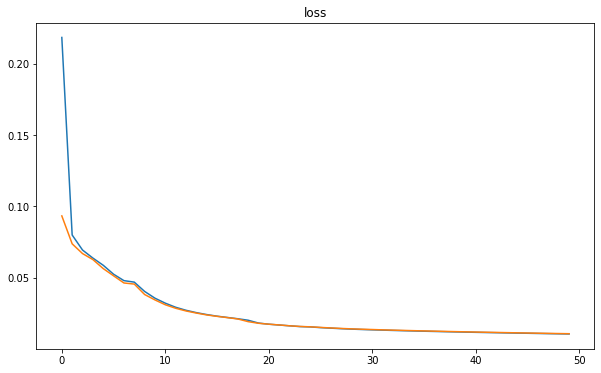

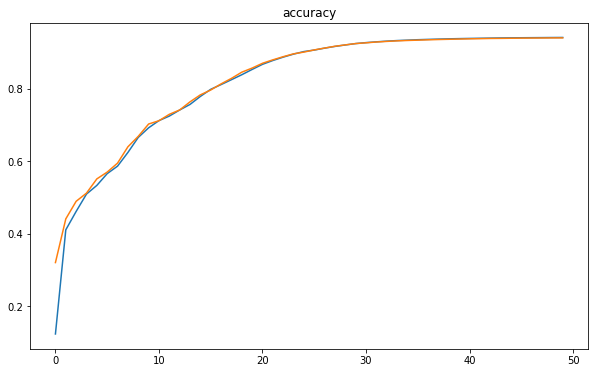

In [ ]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just and <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> this <oov> <oov> of the film are <oov> <oov> a <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really that film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


##Exercise 5.5: Non-Linear Autoencoder for sequences

**To complete: Replicate the code of the exercise above, but instead of using a simpleRNN with linear activations do use non-linear activation functions and a LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.**

**Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.**


In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded_nl = tf.keras.layers.LSTM(25, return_sequences=True, activation='sigmoid')(inputs)

decoded_nl = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='sigmoid'))(encoded_nl)

sequence_autoencoder_nl = tf.keras.models.Model(inputs, decoded_nl)
encoder_nl = tf.keras.models.Model(inputs, encoded_nl)

sequence_autoencoder_nl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder_nl.summary()
history_nl = sequence_autoencoder_nl.fit(X_train_one_hot, X_train_one_hot, epochs=35, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Model: "model_161"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_111 (InputLayer)       [(None, 90, 100)]         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 90, 25)            12600     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 90, 100)           2600      
Total params: 15,200
Trainable params: 15,200
Non-trainable params: 0
_________________________________________________________________
Epoch 1/35
79/79 [==============================] - 8s 102ms/step - loss: 0.0950 - categorical_accuracy: 0.4409 - val_loss: 0.0384 - val_categorical_accuracy: 0.4614
Epoch 2/35
79/79 [==============================] - 8s 99ms/step - loss: 0.0378 - categorical_accuracy: 0.4710 - val_loss: 0.0382 - val_categorical_accuracy: 0.4614
Epoch 3/35
79/79 [==============================] - 

40/40 - 1s - loss: 0.0020 - categorical_accuracy: 1.0000
categorical_accuracy: 100.00%


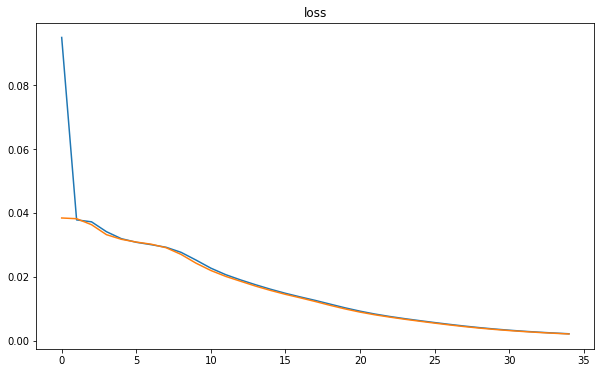

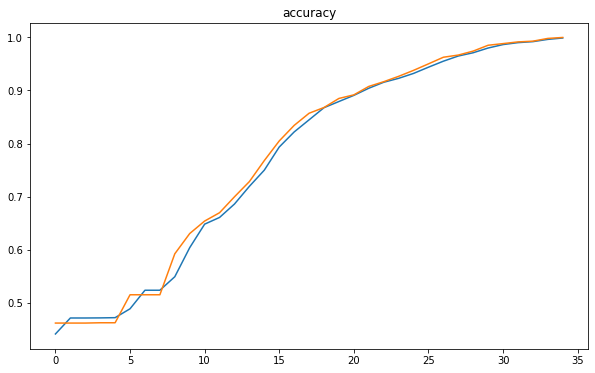

In [ ]:
plot_loss(history_nl)
plot_categorical_accuracy(history_nl)
scores_nl = sequence_autoencoder_nl.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder_nl.metrics_names[1], scores_nl[1]*100))

In [ ]:
decoded_text_nl = sequence_autoencoder_nl.predict(X_test_one_hot)
decode_index_nl = np.argmax(decoded_text_nl[500], axis=1)
input_text_nl = np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text_nl))
print(decode_review(decode_index_nl))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


The non linear autoencoder with LSTM here performs really better than simple RNN, almost reaching the perfection in our dataset, by using half units than the previous. Another time, i used a sigmoid actiovation function, since data is only 0 and 1. 